# Average Daily Power Consumption Prediction



In this notebook, average daily power consumption prediction models are implemented. The models takes the average daily temperature as input and gives the average daily power consumption as output. 

The tested models are:
* Linear Regression
* Polynomial Regression (2º degree)

## Dataset

The data used in this notebook comes from the Kaggle's Electric Power Consumption dataset. This dataset is a CSV file with 3 columns of electric power consumption recorded at a frequency of 6 samples per hour (1 sample every 10 minutes). Each of these 3 columns represents a zone of the city of Tétouan, in Morocco. In addition, the dataset has columns of weather variables, such as temperature and humidity. For this practice, we will only use the consumption of zone 1.

## Code

### Part 1 - Data preparation and exploration

**1º step - import libs**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import statsmodels.api as sm

**2º step - load dataset**

In [2]:
dataset = pd.read_csv("/kaggle/input/electric-power-consumption/powerconsumption.csv")
dataset.index = pd.to_datetime(dataset['Datetime'])
dataset = dataset.drop(['Datetime', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
dataset.head() #Show the first lines of the dataframe

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1
Datetime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620


**3º step - calculate the daily mean of each feature in the dataset**

In [3]:
daily_data = dataset.resample('24h').mean()
daily_data.head()


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1
Datetime,,,,,,
2017-01-01,9.675299,68.519306,0.315146,121.390771,25.993924,28465.232067
2017-01-02,12.476875,71.456319,0.076563,120.404486,27.227410,28869.493671
2017-01-03,12.100000,74.981667,0.076715,120.686014,28.574660,30562.447257
2017-01-04,10.509479,75.459792,0.082417,122.959319,28.827222,30689.831224
2017-01-05,10.866444,71.040486,0.083896,118.749861,29.741437,30802.911393


**4º step - check correlations**

<Axes: >

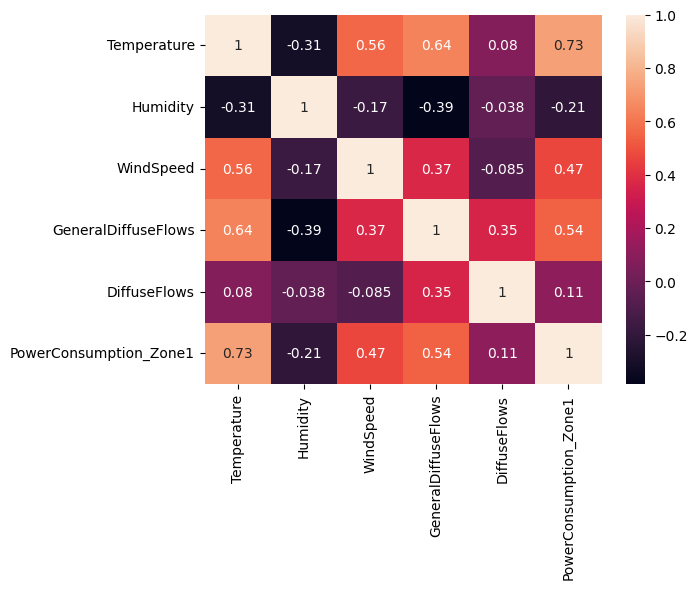

In [4]:
sns.heatmap(daily_data.corr(), annot=True)

The correlation heatmap shows a strong correlation between temperature and consumption. Let's explore this correlation.

**5º step - plot the relationship between temperature and consumption**

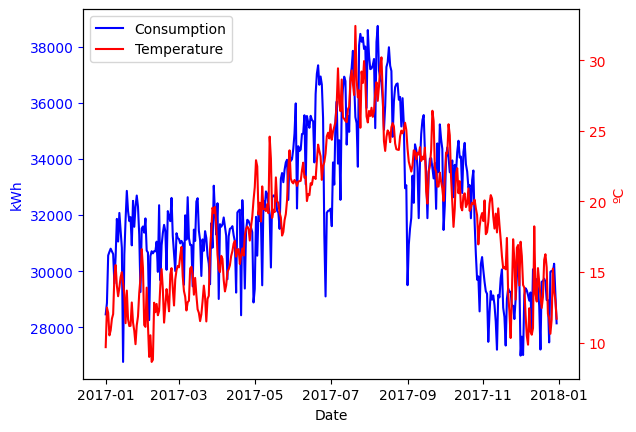

In [5]:
fig, ax1 = plt.subplots()

ax1.plot(daily_data.index, daily_data['PowerConsumption_Zone1'], 'b', label='Consumption')
ax1.set_xlabel('Date')
ax1.set_ylabel('kWh', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()

ax2.plot(daily_data.index, daily_data['Temperature'], 'r', label='Temperature')
ax2.set_ylabel('ºC', color='r')
ax2.tick_params('y', colors='r')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

plt.show()

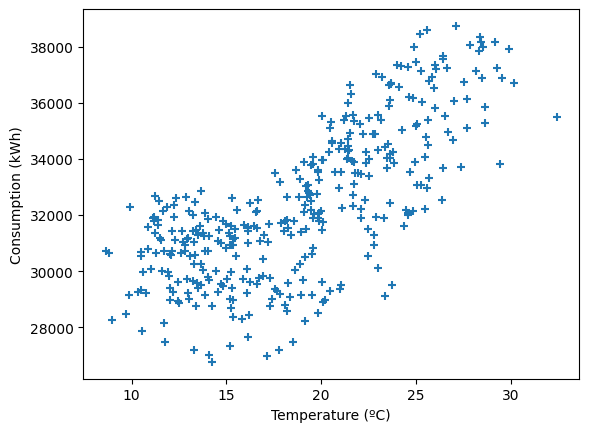

In [6]:
plt.scatter(daily_data['Temperature'], daily_data['PowerConsumption_Zone1'], marker='+')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Consumption (kWh)')
plt.show()

### Part 2 - Linear regression analysis

**1º step - train a linear regression model to predict the consumption based on the temperature**

In [7]:
X = np.expand_dims(np.array(daily_data['Temperature']), axis=1)
y = np.array(daily_data['PowerConsumption_Zone1'])
reg = LinearRegression().fit(X,y)

print(f'Learned function: consumption = temperature*{reg.coef_[0]:.2f} + {reg.intercept_:.2f}')
print(f'R^2 score: {reg.score(X,y)}')

Learned function: consumption = temperature*377.05 + 25252.68
R^2 score: 0.5397780277492816


**2º step - plot the predictions of the linear regression model**

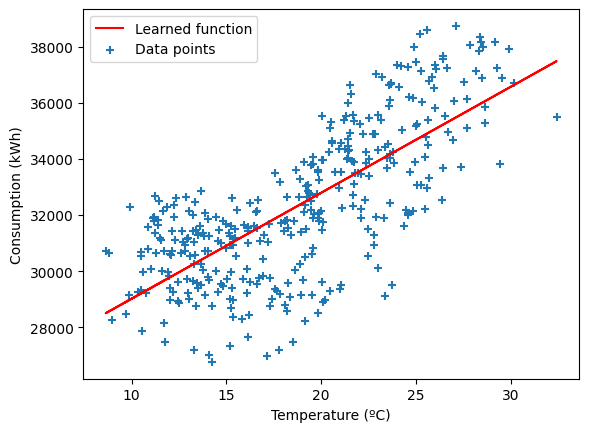

In [8]:
f = lambda x: x*reg.coef_[0] + reg.intercept_
plt.plot(daily_data['Temperature'], daily_data['Temperature'].apply(f), 'red', label='Learned function')
plt.scatter(daily_data['Temperature'], daily_data['PowerConsumption_Zone1'], marker='+', label='Data points')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

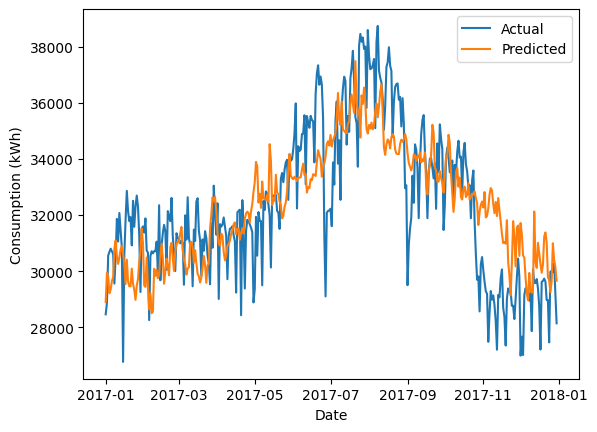

In [9]:
plt.plot(daily_data.index, daily_data['PowerConsumption_Zone1'], label='Actual')
plt.plot(daily_data.index, daily_data['Temperature'].apply(f), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

**3º step - create a copy of daily_data and append the LR predictions and residuals to it**

In [10]:
lr_daily_data = daily_data.copy() #Linear Regression dataframe
lr_daily_data['Prediction'] = 0 #Create a Prediction column and fill it with 0
lr_daily_data['Error'] = 0 #Create an Error column and fill it with 0

def lr_pred_and_error(row):
    row['Prediction'] = f(row['Temperature'])
    row['Error'] = row['PowerConsumption_Zone1'] - row['Prediction'] 
    return row

lr_daily_data = lr_daily_data.apply(lr_pred_and_error, axis=1, result_type='broadcast') 
lr_daily_data

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,Prediction,Error
Datetime,,,,,,,,
2017-01-01,9.675299,68.519306,0.315146,121.390771,25.993924,28465.232067,28900.734190,-435.502123
2017-01-02,12.476875,71.456319,0.076563,120.404486,27.227410,28869.493671,29957.064942,-1087.571271
2017-01-03,12.100000,74.981667,0.076715,120.686014,28.574660,30562.447257,29814.964711,747.482546
2017-01-04,10.509479,75.459792,0.082417,122.959319,28.827222,30689.831224,29215.260889,1474.570335
2017-01-05,10.866444,71.040486,0.083896,118.749861,29.741437,30802.911393,29349.854185,1453.057208
...,...,...,...,...,...,...,...,...
2017-12-26,11.621840,69.070903,0.083062,106.836687,50.760389,30013.476975,29634.675206,378.801769
2017-12-27,15.232917,59.445903,0.082028,95.890674,41.705062,29966.962399,30996.226886,-1029.264487
2017-12-28,13.662361,62.839375,0.081354,112.620160,30.209361,30267.004647,30404.050946,-137.046299


**4º step - make an error histogram**

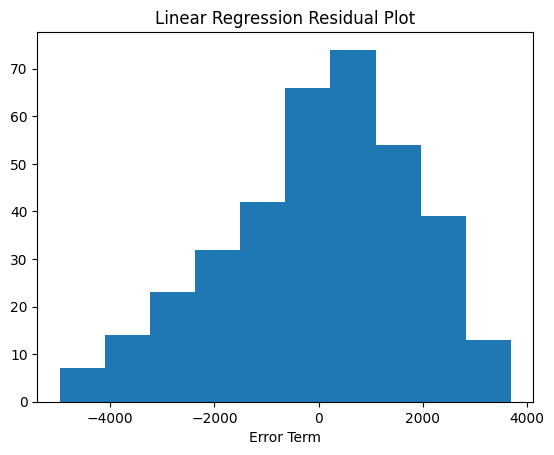

In [11]:
plt.hist(lr_daily_data['Error'])
plt.title('Linear Regression Residual Plot')
plt.xlabel('Error Term')
plt.show()

**5º step - make a q-q plot to check the normality of the error terms**

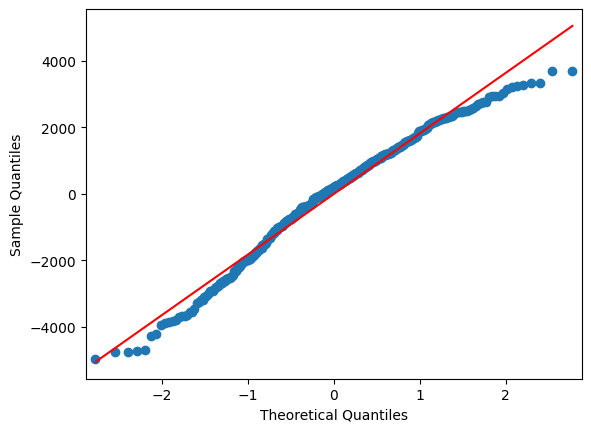

In [12]:
fig = sm.qqplot(lr_daily_data['Error'], line='r')

The histogram and the q-q plot of the error terms shows an almost, but not exactly normal distribution.

**6º step - make a residual plot**

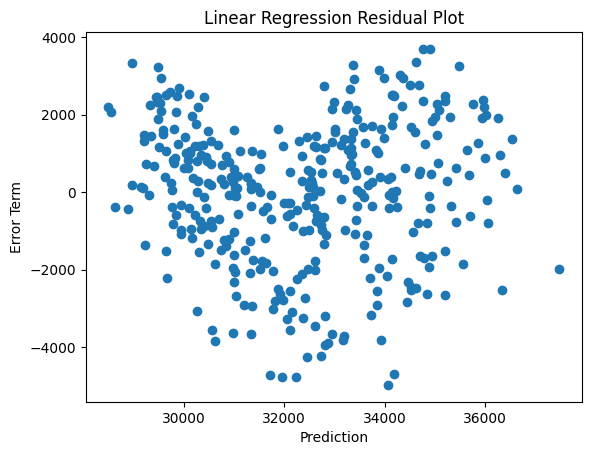

In [13]:
plt.scatter(lr_daily_data['Prediction'], lr_daily_data['Error'])
plt.title('Linear Regression Residual Plot')
plt.xlabel('Prediction')
plt.ylabel('Error Term')
plt.show()

The residual plot shows an U-shaped pattern between the error terms and the predictions, so **the LR model is not a good fit**.

### Part 3 - Polynomial regression analysis

**1º step - train a polynomial regression model to predict the consumption based on the temperature**

In [14]:
def poly_reg(x, t, deg):
    '''
    params:
        x - input data (2D array)
        t - target data (1D array)
        deg - polynomial degree
    '''
    coefs = np.polyfit(X.reshape(-1), y, deg=deg)[::-1]
    print('Learned Function: y =', ' + '.join([f'{coefs[i]:.2f}*(x**{i})' for i in range(len(coefs))]))
    func = lambda x: sum([coefs[i]*(x**i) for i in range(len(coefs))])
    return np.vectorize(func) #Return the vectorized regression function

g = poly_reg(X, y, 2)

print(f'R^2 score: {r2_score(y,g(X))}')

Learned Function: y = 31304.07*(x**0) + -303.16*(x**1) + 17.71*(x**2)
R^2 score: 0.5738314876062907


**2º step - plot the predictions of the polynomial regression model**

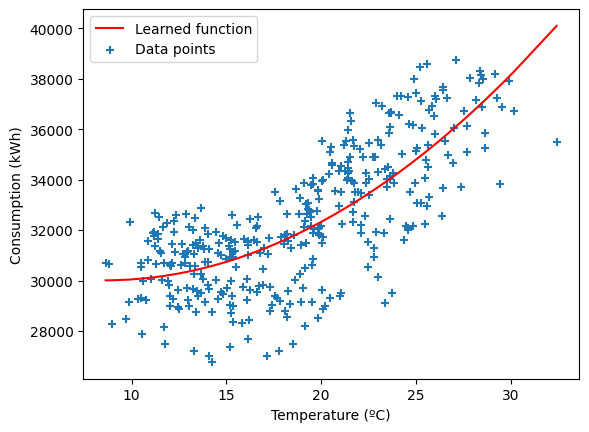

In [15]:
plt.plot(daily_data['Temperature'].sort_values(), daily_data['Temperature'].sort_values().apply(g), 'red', label='Learned function')
plt.scatter(daily_data['Temperature'], daily_data['PowerConsumption_Zone1'], marker='+', label='Data points')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

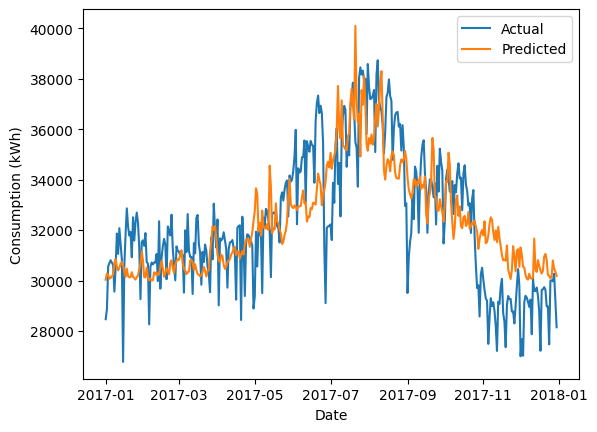

In [16]:
plt.plot(daily_data.index, daily_data['PowerConsumption_Zone1'], label='Actual')
plt.plot(daily_data.index, daily_data['Temperature'].apply(g), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

**3º step - create a copy of daily_data and append the PR predictions and residuals to it**

In [17]:
pr_daily_data = daily_data.copy() #Polynomial Regression dataframe
pr_daily_data['Prediction'] = 0 #Create a Prediction column and fill it with 0
pr_daily_data['Error'] = 0 #Create an Error column and fill it with 0

def pr_pred_and_error(row):
    row['Prediction'] = g(row['Temperature'])
    row['Error'] = row['PowerConsumption_Zone1'] - row['Prediction'] 
    return row

pr_daily_data = pr_daily_data.apply(pr_pred_and_error, axis=1, result_type='broadcast') 
pr_daily_data

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,Prediction,Error
Datetime,,,,,,,,
2017-01-01,9.675299,68.519306,0.315146,121.390771,25.993924,28465.232067,30028.622286,-1563.390218
2017-01-02,12.476875,71.456319,0.076563,120.404486,27.227410,28869.493671,30278.304663,-1408.810992
2017-01-03,12.100000,74.981667,0.076715,120.686014,28.574660,30562.447257,30228.534558,333.912699
2017-01-04,10.509479,75.459792,0.082417,122.959319,28.827222,30689.831224,30073.903633,615.927590
2017-01-05,10.866444,71.040486,0.083896,118.749861,29.741437,30802.911393,30100.810199,702.101194
...,...,...,...,...,...,...,...,...
2017-12-26,11.621840,69.070903,0.083062,106.836687,50.760389,30013.476975,30172.628803,-159.151828
2017-12-27,15.232917,59.445903,0.082028,95.890674,41.705062,29966.962399,30795.170797,-828.208397
2017-12-28,13.662361,62.839375,0.081354,112.620160,30.209361,30267.004647,30467.658905,-200.654257


**4º step - make an error histogram**

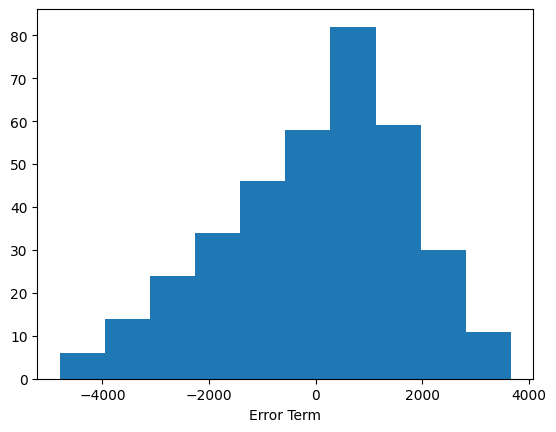

In [18]:
plt.hist(pr_daily_data['Error'])
plt.xlabel('Error Term')
plt.show()

**5º step - make a q-q plot to check the normality of the error terms**

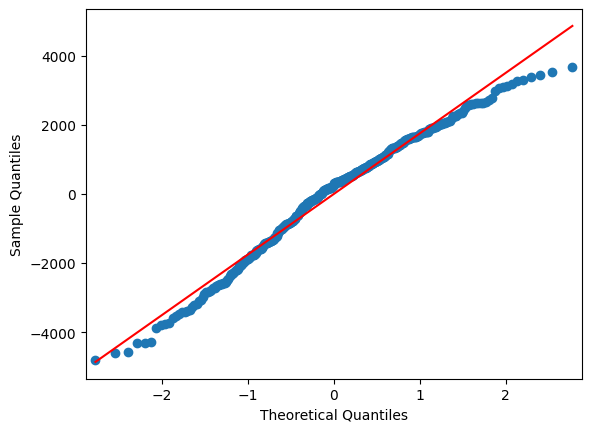

In [19]:
fig = sm.qqplot(pr_daily_data['Error'], line='r')

The histogram and the q-q plot of the error terms shows an almost, but not exactly normal distribution.

**6º step - make a residual plot**

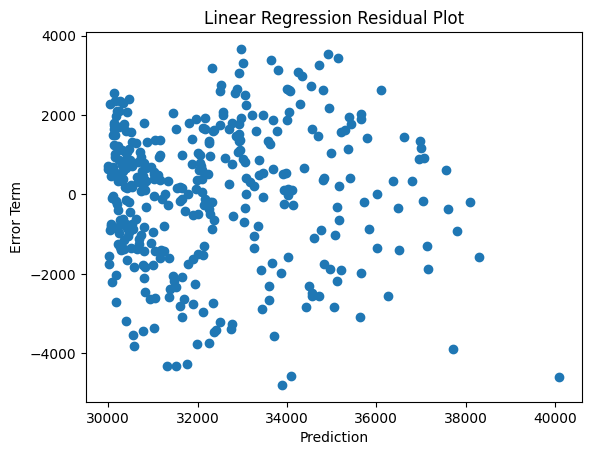

In [20]:
plt.scatter(pr_daily_data['Prediction'], pr_daily_data['Error'])
plt.title('Linear Regression Residual Plot')
plt.xlabel('Prediction')
plt.ylabel('Error Term')
plt.show()

The residual plot showed no dependence between error and prediction, although the error distribution is not a perfect normal. **It can be said that quadratic polynomial regression is a good fit**.